In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Dense, Flatten
from keras import backend as K 

from scipy import interpolate
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
from helpers.composite_helpers import *

curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

run_toy = True

if run_toy:
    dataset_config_string = "triangle_npoints100002_nfeatures2"
    num_signal_to_inject = 1
    
    # load in the reverse rescales
    path_to_minmax = f"/global/home/users/rrmastandrea/CURTAINS_SALAD/{dataset_config_string}/data/col_minmax.npy"
    
    # dataset generation parameters
   


    bands_dict = {"sb1": [0, .34],
                  "sr" : [.34, .66],
                  "sb2": [.66, 1]}
    
    n_features = 1


else:
    n_features = 5
    num_signal_to_inject = 2000
    dataset_config_string = f"LHCO_{num_signal_to_inject}sig_f/"
    STS_config_sting = f"LHCO_STS/"
    
    # load in the reverse rescales
    path_to_minmax = "/global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_STS/data/col_minmax.npy"

    # dataset generation parameters
    context_endpoints = (2500, 4500)


    bands_dict = {"sb1": [2900, 3300],
                  "sr" : [3300, 3700],
                  "sb2": [3700, 4100]}

    


In [3]:
    
exp_dir = os.path.join(curtains_dir, dataset_config_string)
data_dir = os.path.join(exp_dir, "data")
col_minmax = np.load(path_to_minmax)


binning_scheme = np.linspace(-3.5, 3.5, 50)


"""
"""
"""
LOAD IN THE DATASETS AND PROCESS
"""
"""
"""

npull_dataset_train_sim = ToyDataset(data_dir, "train_sim.npy")
npull_dataset_val_sim = ToyDataset(data_dir, "val_sim.npy")
npull_dataset_train_dat = ToyDataset(data_dir, "train_dat.npy")
npull_dataset_val_dat = ToyDataset(data_dir, "val_dat.npy")
classif_train_sim = ToyDataset(data_dir, "classif_train_sim.npy")
classif_train_dat = ToyDataset(data_dir, "classif_train_dat.npy")

print("Num SIM events in SB:", len(npull_dataset_train_sim)+len(npull_dataset_val_sim))
print("Num DAT events in SB:", len(npull_dataset_train_dat)+len(npull_dataset_val_dat))
print()

# Preprocess the data
print("Preproccessing data...")
print()
dataset_train_sim = npull_dataset_train_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_val_sim = npull_dataset_val_sim.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_train_dat = npull_dataset_train_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])
dataset_val_dat = npull_dataset_val_dat.pull_from_mass_range([bands_dict["sb1"], bands_dict["sb2"]])

dataset_sr_sim = classif_train_sim.pull_from_mass_range([bands_dict["sr"]])
dataset_sr_dat = classif_train_dat.pull_from_mass_range([bands_dict["sr"]])

dataset_train_sim = minmaxscale(dataset_train_sim.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_val_sim = minmaxscale(dataset_val_sim.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_train_dat = minmaxscale(dataset_train_dat.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_val_dat = minmaxscale(dataset_val_dat.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_sr_sim = minmaxscale(dataset_sr_sim.data, col_minmax, lower = -3, upper = 3, forward = True)
dataset_sr_dat = minmaxscale(dataset_sr_dat.data, col_minmax, lower = -3, upper = 3, forward = True)




Num SIM events in SB: 100002
Num DAT events in SB: 68004

Preproccessing data...



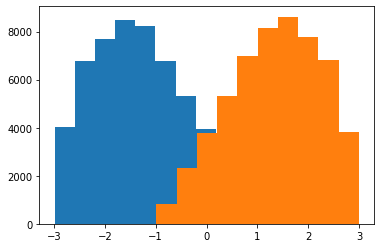

In [4]:

ind = 0

plt.figure()

plt.hist(dataset_train_sim[:,ind])
plt.hist(dataset_train_dat[:,ind])
plt.show()




# Actually train SALAD

In [5]:
#Next is SALAD


stored_weights = {}


def get_weights(data, model):
    yhat = model.predict(data, batch_size=128)
    return np.squeeze(yhat/(1 - yhat))


X_SALAD_sb_train = np.concatenate([dataset_train_sim, dataset_train_dat])
Y_SALAD_sb_train = np.concatenate([np.zeros(len(dataset_train_sim)), np.ones(len(dataset_train_dat))])

X_SALAD_val = np.concatenate([dataset_val_sim, dataset_val_dat])
Y_SALAD_val = np.concatenate([np.zeros(len(dataset_val_sim)),np.ones(len(dataset_val_dat))])

# testing set
X_SALAD_sr_train = np.concatenate([dataset_sr_sim, dataset_sr_dat])
Y_SALAD_sr_train = np.concatenate([np.zeros(len(dataset_sr_sim)), np.ones(len(dataset_sr_dat))])

X_SALAD_sb_train = X_SALAD_sb_train[:,:n_features]
X_SALAD_val = X_SALAD_val[:,:n_features]
X_SALAD_sr_train = X_SALAD_sr_train[:,:n_features]



print('Training...')

tf.keras.backend.clear_session()
model_SALAD_sb = Sequential()
model_SALAD_sb.add(Dense(64, input_dim=n_features, activation='relu')) 
model_SALAD_sb.add(Dense(64, activation='relu'))
model_SALAD_sb.add(Dense(64, activation='relu'))
model_SALAD_sb.add(Dense(1, activation='sigmoid'))
model_SALAD_sb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

EPOCHS = 70

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint(f'{num_signal_to_inject}.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, epsilon=1e-7, mode='min')


hist_SALAD_sb = model_SALAD_sb.fit(
    X_SALAD_sb_train, Y_SALAD_sb_train, epochs=EPOCHS,
    batch_size=int(256), verbose=0, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_SALAD_val, Y_SALAD_val)
)




print("done")


Training...

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
done


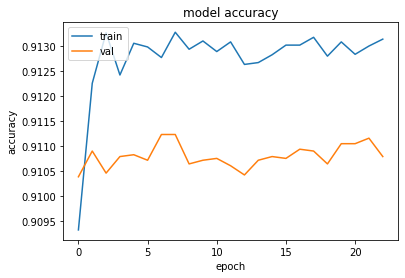

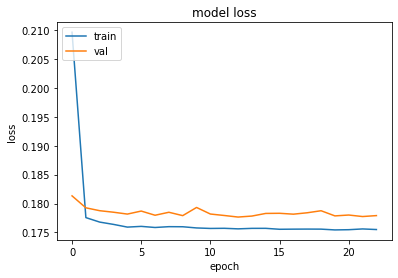

In [6]:

plt.plot(hist_SALAD_sb.history['accuracy'])
plt.plot(hist_SALAD_sb.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

     
plt.plot(hist_SALAD_sb.history['loss'])
plt.plot(hist_SALAD_sb.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
model_SALAD_sb.load_weights(f'{num_signal_to_inject}.mdl_wts.hdf5')
print("Evaluating at best val loss epoch:", np.argmin(hist_SALAD_sb.history['val_loss']))

# apply weight function
W_SALAD_sr_train = np.ones_like(Y_SALAD_sr_train)
W_SALAD_sr_train[Y_SALAD_sr_train == 0] = get_weights(X_SALAD_sr_train[Y_SALAD_sr_train == 0], 
                                                     model_SALAD_sb)


Evaluating at best val loss epoch: 12


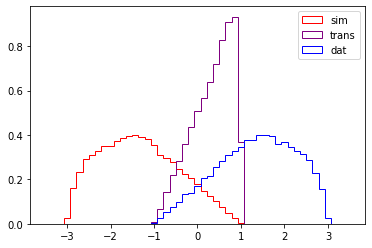

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.42415626e-15,
       1.61387742e-13, 1.26647444e-12, 9.25745197e-12, 5.91036194e-11,
       3.66833154e-10, 2.30308300e-09, 1.38088851e-08, 8.84612503e-08,
       5.39145832e-07, 3.21976018e-06, 1.94699981e-05, 1.13318618e-04,
       6.71859998e-04, 8.77587797e-03, 6.83664931e-02, 1.43995251e-01,
       2.20881829e-01, 2.84968063e-01, 3.61674345e-01, 4.35752084e-01,
       5.06354864e-01, 5.67855070e-01, 6.40081440e-01, 7.18702344e-01,
       8.29428051e-01, 9.10408791e-01, 9.33213642e-01, 3.68733344e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00]), array([-3.5       , -3.35714286, -3.21428571, -3.07142857, -2.92857143,
       -2.78571429, -2.64285714, -2.5       , -2.3

In [8]:
# plot with weights
plot_weights =  get_weights(dataset_train_sim[:,0], model_SALAD_sb)

plt.figure()



binning_scheme = np.linspace(-3.5, 3.5, 50)

plt.hist(dataset_train_sim[:,0], bins =binning_scheme, density = True, histtype = "step", color = "red", label = "sim")
a = plt.hist(dataset_train_sim[:,0],  bins =binning_scheme,weights = plot_weights, density = True, histtype = "step", color = "purple", label = "trans")

plt.hist(dataset_train_dat[:,0],  bins =binning_scheme,density = True, histtype = "step", color = "blue", label = "dat")

plt.legend()
plt.show()


print(a)


# Final evaluation

In [9]:
#!/usr/bin/env python
# coding: utf-8

import torch
import os
from numba import cuda 

from helpers.composite_helpers import *


device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)


Using device: cuda


## Reprocess all the samples

In [10]:
X_SALAD_sr_train = minmaxscale(X_SALAD_sr_train, col_minmax, lower = -3, upper = 3, forward = False)
X_SALAD_sr_train = minmaxscale(X_SALAD_sr_train, col_minmax, lower = 0, upper = 1, forward = True)

"""
plt.figure()
plt.hist(X_SALAD_sr_train[:,0])
plt.show()
"""

'\nplt.figure()\nplt.hist(X_SALAD_sr_train[:,0])\nplt.show()\n'

In [11]:
def loc_analyze_band_transform(dir_to_save, idd, nn_train_data, nn_train_labs, class_weights, test_samp_1, test_samp_2, n_features, n_epochs, batch_size, lr, patience, device, update_epochs = 1, early_stop = True, visualize = True, seed = None):
    
    if seed is not None:
        #print(f"Using seed {seed}...")
        torch.manual_seed(seed)
        np.random.seed(seed)
            
    dense_net = NeuralNet(input_shape = n_features)
    criterion = F.binary_cross_entropy #nn.BCELoss()
    optimizer = torch.optim.Adam(dense_net.parameters(), lr=lr)

    dense_net.to(device)
    
    if early_stop:
        early_stopping = EarlyStopping(patience=patience)
    
        
    # train-test split
    val_size = 0.2
    
    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(nn_train_data, nn_train_labs, test_size=val_size)
    

    nn_test_data = np.concatenate((test_samp_1, test_samp_2))
    nn_test_labs = np.concatenate((torch.zeros((test_samp_1.shape[0], 1)), torch.ones((test_samp_2.shape[0],1))))
    # shuffle the data
    nn_train_data, nn_train_labs = shuffle(nn_train_data, nn_train_labs)
    X_test, y_test = shuffle(nn_test_data, nn_test_labs)

    
    print("Train data, labels shape:", X_train.shape, y_train.shape)
    print("Val data, labels shape:", X_val.shape, y_val.shape)
    print("Test data, labels  shape:", X_test.shape, y_test.shape)
    
    for i in range(X_train.shape[1]):
        print(f"Feature {i} min, max for train: ({np.min(X_train[:,i])},{np.max(X_train[:,i])}), val: ({np.min(X_val[:,i])},{np.max(X_val[:,i])}), test: ({np.min(X_test[:,i])},{np.max(X_test[:,i])})")  
        
    # send to device
    X_train = np_to_torch(X_train, device)
    X_val = np_to_torch(X_val, device)
    X_test = np_to_torch(X_test, device)
    y_train = np_to_torch(y_train, device)
    y_val = np_to_torch(y_val, device)
    

    epochs, epochs_val = [], []
    losses, losses_val = [], []

    for epoch in tqdm(range(n_epochs)):
        # batching
        indices_list = torch.split( torch.randperm( X_train.shape[0] ), batch_size )
        # initialise lists to store batch stats
        losses_batch_per_e = []
        
        for i, indices in enumerate( indices_list ): # going through the batches
            # calculate the loss, backpropagate
            optimizer.zero_grad()
            
            batch_data = X_train[indices]
            batch_labels = y_train[indices]
            
            # get the weights
            batch_weights = (torch.ones(batch_labels.shape, device=device)
                        - batch_labels)*class_weights[0] \
                        + batch_labels*class_weights[1]

            
            loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses_batch_per_e.append(loss.detach().cpu().numpy())

        epochs.append(epoch)
        losses.append(np.mean(losses_batch_per_e))
        
        # validation
        if epoch % update_epochs == 0:
            
            with torch.no_grad():
                # batching
                val_indices_list = torch.split( torch.randperm( X_val.shape[0] ), batch_size )
                # initialise lists to store batch stats
                val_losses_batch_per_e = []

                for i, indices in enumerate( val_indices_list ): # going through the batches
                    # calculate the loss, backpropagate
                    optimizer.zero_grad()
                    
                    batch_data = X_val[indices]
                    batch_labels = y_val[indices]

                    # get the weights
                    batch_weights = (torch.ones(batch_labels.shape, device=device)
                                - batch_labels)*class_weights[0] \
                                + batch_labels*class_weights[1]

                    
                    val_loss = criterion(dense_net(batch_data), batch_labels, weight = batch_weights) 

                    val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

            epochs_val.append(epoch)
            losses_val.append(np.mean(val_losses_batch_per_e))
            
            if early_stop:
                early_stopping(np.mean(val_losses_batch_per_e))
                
        if early_stopping.early_stop:
            break

    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(epochs, losses)
        ax.plot(epochs_val, losses_val, label = "val")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(idd)
        fname = f"{dir_to_save}/losses_{idd}"
        fig.savefig(fname)

    # evaluate

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        outputs = dense_net(X_test).detach().cpu().numpy()
        predicted = np.round(outputs)

        # calculate auc 
        auc = roc_auc_score(y_test, outputs)
        fpr, tpr, _ = roc_curve(y_test, outputs)

    if visualize:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title("ROC: " + str(auc))
        fname = f"{dir_to_save}/roc_{idd}"
        fig.savefig(fname)
        
    np.save(f"{dir_to_save}/fpr_{idd}", fpr)
    np.save(f"{dir_to_save}/tpr_{idd}", tpr)
        
    if auc < 0.5:
        auc = 1.0 - auc
    
    return auc


In [12]:
epochs_NN =  100
batch_size_NN = 128
lr_NN = 0.001
patience_NN = 20



Evaluating toy model case...
On classifier seed 0...


NameError: name 'STS_bkg_dataset' is not defined